1

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
from sklearn.svm import SVC

2

In [2]:
# ===== 1. Đọc dữ liệu =====
df_sample = pd.read_csv("online_shoppers_intention.csv")
df = df_sample.sample(frac = 0.1, random_state = 42)

3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1233 entries, 8916 to 7054
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           1233 non-null   int64  
 1   Administrative_Duration  1233 non-null   float64
 2   Informational            1233 non-null   int64  
 3   Informational_Duration   1233 non-null   float64
 4   ProductRelated           1233 non-null   int64  
 5   ProductRelated_Duration  1233 non-null   float64
 6   BounceRates              1233 non-null   float64
 7   ExitRates                1233 non-null   float64
 8   PageValues               1233 non-null   float64
 9   SpecialDay               1233 non-null   float64
 10  Month                    1233 non-null   object 
 11  OperatingSystems         1233 non-null   int64  
 12  Browser                  1233 non-null   int64  
 13  Region                   1233 non-null   int64  
 14  TrafficType              1

In [4]:
df['Revenue'] = df['Revenue'].map({True: 1, False: -1})

# ===== 3. One-hot encoding =====
df = pd.get_dummies(df, columns=['Month', 'VisitorType', 'Weekend'], drop_first=True)

# ===== 4. Xử lý missing value =====
df = df.dropna()

# ===== 5. Tách đặc trưng và nhãn =====
X = df.drop('Revenue', axis=1).values
y = df['Revenue'].values.astype(float)


In [5]:
# ===== 6. Train/Test split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===== 7. Chuẩn hóa =====
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# ===== 8. RBF Kernel =====
def rbf_cal(a, b, gamma):
    # Tính ||x - y||^2 = ||x||^2 + ||y||^2 - 2 x^T y
    a_norm = np.sum(a ** 2, axis=1).reshape(-1, 1)  # (n_samples_a, 1)
    b_norm = np.sum(b ** 2, axis=1).reshape(1, -1)  # (1, n_samples_b)
    K = np.exp(-(a_norm + b_norm - 2 * np.dot(a, b.T))*gamma)
    return K

# Áp dụng SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(pd.Series(y_resampled).value_counts())

-1.0    820
 1.0    820
Name: count, dtype: int64


In [7]:
# ===== 9. Tính ma trận Gram (train) =====
n_samples = X_resampled.shape[0]
gamma = 1/X_resampled.shape[1]
K = rbf_cal(X_resampled, X_resampled, gamma)

In [8]:


# ===== 10. QP input =====
C = 1.0 # Regularization parameter
P = matrix(np.outer(y_resampled, y_resampled) * K)
q = matrix(-np.ones(n_samples))
G = matrix(np.vstack([-np.eye(n_samples), np.eye(n_samples)])) 
h = matrix(np.hstack([np.zeros(n_samples), np.ones(n_samples) * C])) 
A = matrix(y_resampled.reshape(1, -1)) 
b = matrix(0.0) 



In [9]:
# ===== 11. Solve QP =====
solvers.options['show_progress'] = False 
solvers.options['abstol'] = 1e-5
solvers.options['reltol'] = 1e-5
solvers.options['feastol'] = 1e-7

sol = solvers.qp(P, q, G, h, A, b)
alphas = np.ravel(sol['x']) 

In [10]:
# ===== 12. Support vectors =====
threshold = 1e-5
sv = (alphas > threshold) & (alphas <= C)
sv_X = X_resampled[sv] #support vectors
sv_y = y_resampled[sv]
sv_alpha = alphas[sv]

# 2. Xác định các Margin Vectors (0 < alpha_i < C)
margin_mask = (alphas > threshold) & (alphas < C - threshold)
margin_X = X_resampled[margin_mask]
margin_y = y_resampled[margin_mask]

 Evaluation on Test Set:
Accuracy : 0.8421
Precision: 0.4839
Recall   : 0.8108
F1 Score : 0.6061


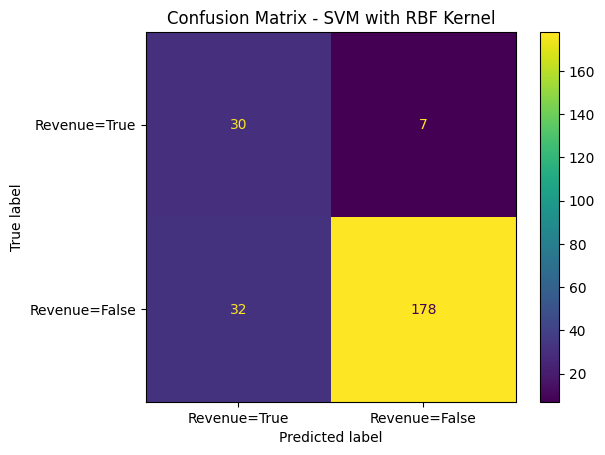

In [11]:
if len(margin_X) > 0:
    K_ms = rbf_cal(margin_X, sv_X, gamma)
    # Tính b cho các Margin Vectors
    a_s = sv_alpha * sv_y
    b = np.dot((margin_y - np.dot(K_ms, a_s)).T, np.ones(len(margin_X))) / len(margin_X)
else:
    N = rbf_cal(sv_X[0:1], sv_X, gamma)
    a_s = sv_alpha * sv_y
    b = sv_y[0] - np.dot(N, a_s)[0]

# ===== 13. Dự đoán =====
def project(x):
    x = np.asarray(x)
    if x.ndim == 1:
        x = x.reshape(1, -1)
    # Tính K_bs: kernel giữa x và các support vectors
    K_bs = rbf_cal(x, sv_X, gamma)
    
    # Tính y = K_bs * a_s + b
    y = np.dot(K_bs, sv_alpha * sv_y) + b
    # Trả về mảng 1D
    return y.ravel()

def predict(X_test):
    return np.sign(project(X_test))

# ===== 14. Dự đoán và đánh giá =====
y_pred = predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, pos_label=1)
rec = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

# print(pd.Series(y_test).value_counts())
print(f" Evaluation on Test Set:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")

# ===== 15. Confusion Matrix =====
cm = confusion_matrix(y_test, y_pred, labels=[1, -1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Revenue=True", "Revenue=False"])
disp.plot()
plt.title("Confusion Matrix - SVM with RBF Kernel")
plt.show()


 Evaluation on Test Set:
Accuracy : 0.8421
Precision: 0.4839
Recall   : 0.8108
F1 Score : 0.6061


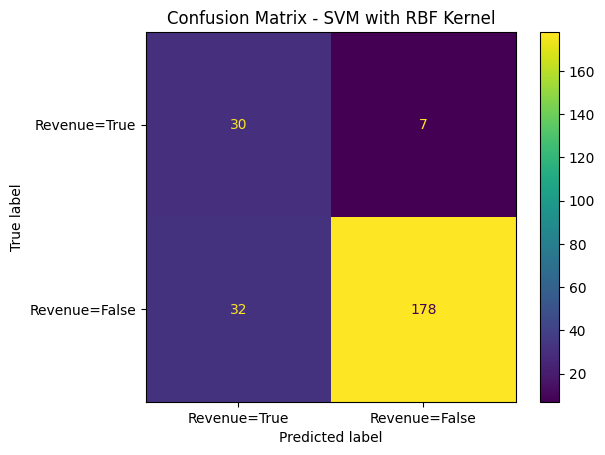

In [12]:
model = SVC(C=1.0, kernel='rbf', gamma = gamma)
model.fit(X_resampled, y_resampled.reshape(-1,))

y_pre = model.predict(X_test)

acu = accuracy_score(y_test, y_pre)
preci = precision_score(y_test, y_pre, pos_label=1)
reca = recall_score(y_test, y_pre, pos_label=1)
f1s = f1_score(y_test, y_pre, pos_label=1)

print(f" Evaluation on Test Set:")
print(f"Accuracy : {acu:.4f}")
print(f"Precision: {preci:.4f}")
print(f"Recall   : {reca:.4f}")
print(f"F1 Score : {f1s:.4f}")

# ===== 15. Confusion Matrix =====
cm = confusion_matrix(y_test, y_pre, labels=[1, -1])
abc = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Revenue=True", "Revenue=False"])
abc.plot()
plt.title("Confusion Matrix - SVM with RBF Kernel")
plt.show()
